# Model Training & Evaluation

# **Goal**: Compare different ML models for churn prediction


In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/customer_churn_prediction/raw/telco.csv")

# Data Cleaning (based on previous exploration)
# Convert TotalCharges to numeric, handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop customer ID (not useful for modeling)
df = df.drop('customerID', axis=1)

# Convert Churn to binary numeric
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

Original Class Distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Churn Rate: 0.2653698707936959


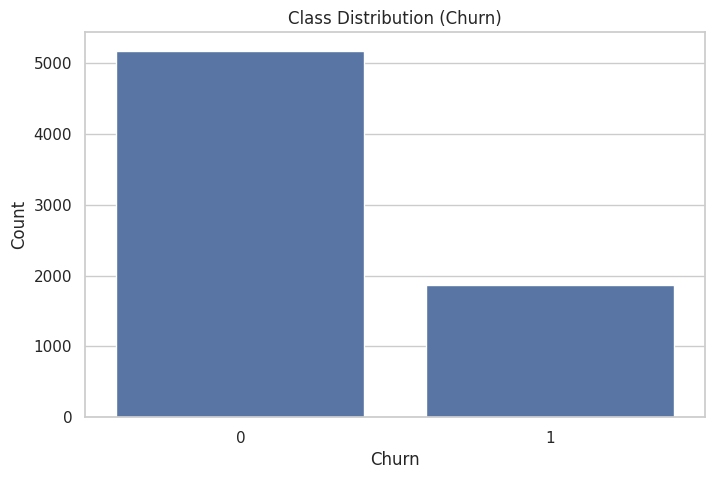

In [4]:
# Define categorical and numeric features
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                   'PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaperlessBilling', 'PaymentMethod']

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Display class distribution
print("Original Class Distribution:")
print(y.value_counts(normalize=True))
print("\nChurn Rate:", y.mean())

# Visualize class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Class Distribution (Churn)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [5]:
# Split data into train and test sets (stratified by churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Save the preprocessor for later use in deployment
joblib.dump(preprocessor, 'preprocessor.pkl')

Training set size: 5634 samples
Test set size: 1409 samples


['preprocessor.pkl']

In [6]:
# Option 1: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

# Option 2: Class Weighting
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("\nResampled Class Distribution (SMOTE):")
print(pd.Series(y_train_res).value_counts(normalize=True))


Resampled Class Distribution (SMOTE):
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



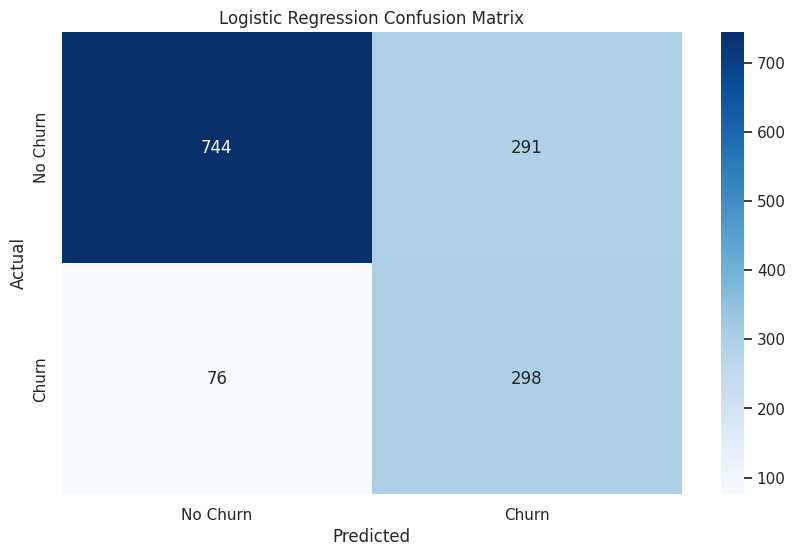


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



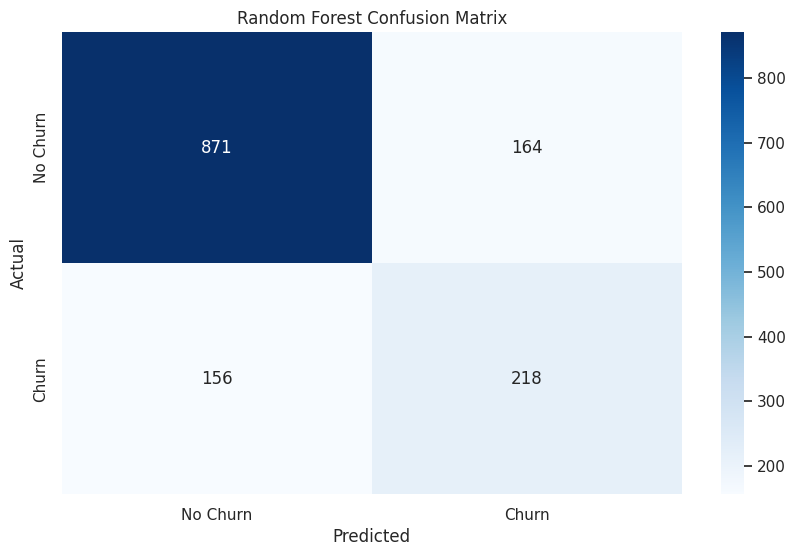


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.69      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409



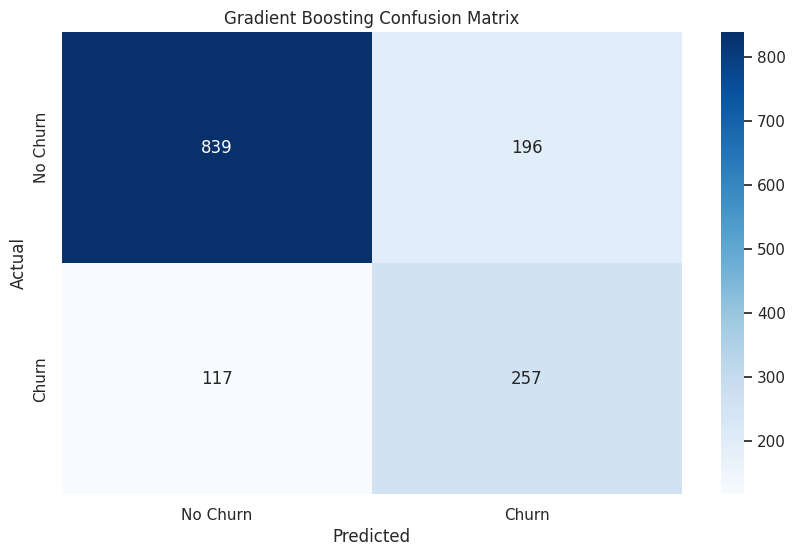


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.75      0.76      1409



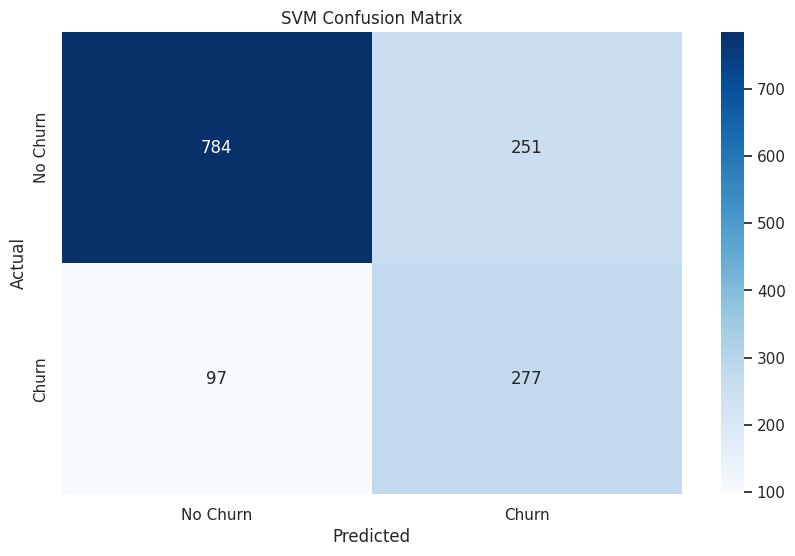


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.739532   0.505942  0.796791  0.618899  0.839960
3                  SVM  0.753016   0.524621  0.740642  0.614191  0.822194
2    Gradient Boosting  0.777857   0.567329  0.687166  0.621524  0.841490
1        Random Forest  0.772889   0.570681  0.582888  0.576720  0.822828


In [7]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

# Train and evaluate models
results = []
for name, model in models.items():
    # Train
    model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Compare model performance
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values(by='Recall', ascending=False))


Selected Model for Tuning: Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.8147

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



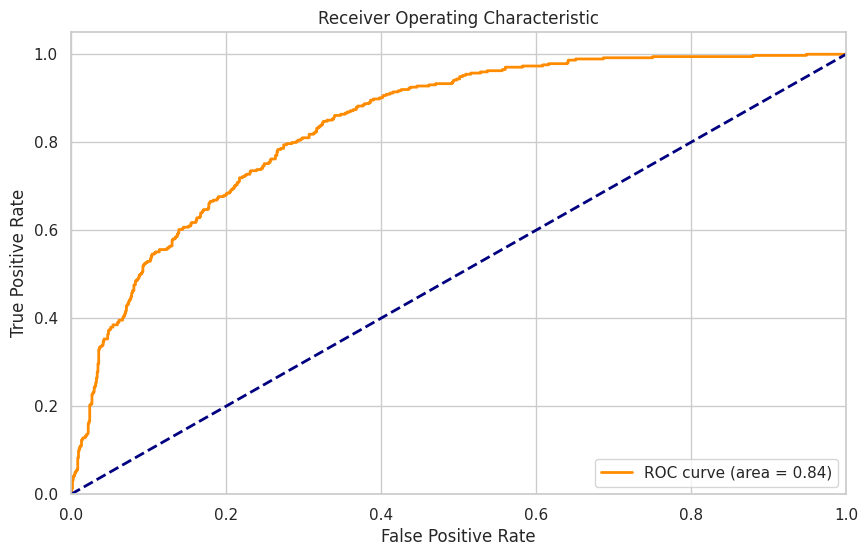

In [8]:
# Select best model based on recall (since we want to minimize false negatives)
best_model_name = results_df.sort_values(by='Recall', ascending=False).iloc[0]['Model']
print(f"\nSelected Model for Tuning: {best_model_name}")

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    model = GradientBoostingClassifier(random_state=42)
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    model = LogisticRegression(random_state=42, class_weight='balanced')
else:  # SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
    model = SVC(probability=True, random_state=42, class_weight='balanced')

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
y_pred = best_model.predict(X_test_processed)
y_proba = best_model.predict_proba(X_test_processed)[:, 1]

print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Feature Importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after one-hot encoding
    ohe = preprocessor.named_transformers_['cat']
    feature_names = numeric_cols + list(ohe.get_feature_names_out(categorical_cols))

    # Plot feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(20), importances[indices][:20], align="center")
    plt.xticks(range(20), np.array(feature_names)[indices][:20], rotation=90)
    plt.xlim([-1, 20])
    plt.tight_layout()
    plt.show()

# Save the best model
joblib.dump(best_model, 'churn_model.pkl')
print("\nBest model saved as 'churn_model.pkl'")


Best model saved as 'churn_model.pkl'


In [10]:
# Create a sample input for testing the app
sample_customer = X_train.iloc[0:1].copy()
sample_customer.to_csv('sample_customer.csv', index=False)
print("\nSample customer data saved for app testing")

# Create requirements file
!pip freeze > requirements.txt
print("\nRequirements file created")


Sample customer data saved for app testing

Requirements file created
